# Multi-group Agreement
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for several tabular datasets with overlapping group structure. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# Import seaborn
import seaborn as sns
# Apply the default theme
sns.set_theme()

from sklearn.model_selection import train_test_split
from preprocess_data import preprocess_compas, preprocess_adult, preprocess_communities, preprocess_german, preprocess_employment, preprocess_income

# Preprocess Data
Preprocessing is all done separately in `preprocess_data.py`. This notebook
supports the following datasets, by setting the `DATASET` varaible to:
- `adult`: Adult dataset. $n = 45,222, d = 12$. Groups: *Race* and *Sex*.
- `compas`: COMPAS dataset. $n = 7214, d = 10$. Groups: *Race* anad *Sex*.
- `communities`: Communities and Crime dataset. $n = 1,994, d = 113$. Groups: *Race* and *Income level*.
- `german`: German Credit dataset. $n = 1,000, d = 22$. Groups: *Sex* and *Age*.
- `employment`: Folktables Employment dataset from CA. $n = 376,035, d = 17$. Groups: *Race*, *Sex*, *Age*.
- `income`: Folktables Income dataset from CA. $n = 499,350, d = 20$. Groups: *Race*, *Sex*, *Age*.

In [2]:
# Dataset variable
DATASET = 'income'
FOLKTABLES = False
if DATASET == 'adult':
    group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
    agreement_ticks = ['G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)']
    X, y, col_transf, group_memberships = preprocess_adult()
elif DATASET == 'compas':
    group_names = ["ALL", "W,M", "W,F", "nW,M", "nW,F", "W", "nW", "M", "F"]
    agreement_ticks = ['G1 (W,M)', 'G2 (W,F)', 'G3 (nW,M)', 'G4 (nW,F)']
    X, y, col_transf, group_memberships = preprocess_compas()
elif DATASET == 'communities':
    group_names = ["ALL", "W,H", "W,L", "nW,H", "nW,L", "W", "nW", "H", "L"]
    agreement_ticks = ['G1 (W,H)', 'G2 (W,L)', 'G3 (nW,H)', 'G4 (nW,L)']
    X, y, col_transf, group_memberships = preprocess_communities()
elif DATASET == 'german':
    group_names = ["ALL", "M,O", "M,Y", "F,O", "F,Y", "M", "F", "O", "Y"]
    agreement_ticks = ['G1 (M,O)', 'G2 (M,Y)', 'G3 (F,O)', 'G4 (F,Y)']
    X, y, col_transf, group_memberships = preprocess_german()
elif DATASET == 'employment':
    group_names = ["ALL", "R1", "R2", "R3", "R6", "R7", "R8", "R9", 
                   "M", "F", "Y", "O"]
    X, y, col_transf, group_memberships, group_members_all = preprocess_employment()
    FOLKTABLES = True
elif DATASET == 'income':
    group_names = ["ALL", "R1", "R2", "R3", "R6", "R7", "R8", "R9", 
                   "M", "F", "Y", "O"]
    X, y, col_transf, group_memberships, group_members_all = preprocess_income()
    FOLKTABLES = True

num_groups = len(group_memberships)
if FOLKTABLES:
    num_groups_all = len(group_members_all)

ACS Income Features: ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P']
ACS Income Shape (190187, 10)
num_groups = 12
Column-transformed X has shape: (190187, 733)


## Utilities for Training/Evaluation

In [3]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def group_test_errs(yhats, y_test, group_test, num_groups, num_group_test, group_names):
    # Get test errors for each group
    test_err = {}
    std_errs = {}
    print("Group-conditional ERM Test Errors")
    for g in range(num_groups):
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        std_errs[g] = std_err(test_err[g], num_group_test[g])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, test_err[g], std_errs[g], num_group_test[g], group_names[g]))

    print()

    erm_test_err = {}
    erm_std_errs = {}
    print("Overall ERM Test Errors")
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
        erm_std_errs[g] = std_err(erm_test_err[g], num_group_test[g])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, erm_test_err[g], erm_std_errs[g], num_group_test[g], group_names[g]))

    return test_err, std_errs, erm_test_err, erm_std_errs
    
def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

# Group Agreement

In [4]:
from plotting_utils import plot_adult_agreements, plot_adult_errors
from preprocess_data import gen_group_pairs

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

# Construct pairs of groups for "agreement" comparison
print(num_groups)
_, group_pairs, group_pairs_cond = gen_group_pairs(num_groups, FOLKTABLES)

if FOLKTABLES:
    # Get each intersection
    race_sex_pairs = group_pairs[0]
    race_sex_cond = group_pairs_cond[0]
    race_age_pairs = group_pairs[1]
    race_age_cond = group_pairs_cond[1]
    sex_age_pairs = group_pairs[2]
    sex_age_cond = group_pairs_cond[2]

12


In [5]:
# Utility function for calculating group agreement
def group_agreement(pred, groups, group_pairs, group_pairs_cond):
    agreements = []
    for i, (g1, g2) in enumerate(group_pairs):
        intersection = group_pairs_cond[i]
        agree = np.sum(pred[g1][groups[intersection]] == pred[g2][groups[intersection]])/len(pred[0][groups[intersection]])
        agreements.append(agree)
    return agreements

In [6]:
# Generate 1000 bootstrap samples to get confidence intervals for agreement
if FOLKTABLES:
    num_groups = 12
    group_pairs = race_sex_pairs + race_age_pairs + sex_age_pairs
    group_pairs_cond = race_sex_cond + race_age_cond + sex_age_cond
    group_memberships = group_members_all

# Get best parameterse from hyperparameter sweeps
SAVE_DATA_PATH = '{}_agreement_data/'.format(DATASET)
dec_tree_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
with open(dec_tree_path, 'rb') as f:
        dec_tree_params = pickle.load(f)
logreg_params = {'max_iter': 250}
X_all = col_transf.transform(X)
assert(X_all.shape[0] == len(y))

# Wrap in a function to parallelize
def get_agreements():
    # Bootstrap from full dataset
    splits = resample(*tuple([X_all, y] + group_memberships), replace=True,
                    n_samples=X_all.shape[0])
    X_boot = splits[0]
    y_boot = splits[1]
    groups_boot = splits[2:]

    # Train-test split
    splits = train_test_split(*tuple([X_boot, y_boot] + groups_boot),
                            test_size=0.2, random_state=0)
    X_train_b = splits[0]
    X_test_b = splits[1]
    y_train_b = splits[2]
    y_test_b = splits[3]

    # group_train
    group_train_b = splits[4::2]
    group_test_b = splits[5::2]

    # Fit models
    logreg_models_b = {}
    dectree_models_b = {}
    tree_train_pred_b = {}
    tree_test_pred_b = {}
    logreg_train_pred_b = {}
    logreg_test_pred_b = {}
    for g in range(num_groups):
        # Fit and predict with decision trees
        dectree_models_b[g] = DecisionTreeClassifier(**dec_tree_params[g])
        dectree_models_b[g].fit(X_train_b[group_train_b[g]], 
                                y_train_b[group_train_b[g]])
        tree_train_pred_b[g] = dectree_models_b[g].predict(X_train_b)
        tree_test_pred_b[g] = dectree_models_b[g].predict(X_test_b)

        # Fit and predict with logistic regression
        logreg_models_b[g] = LogisticRegression()
        logreg_models_b[g].fit(X_train_b[group_train_b[g]], 
                                y_train_b[group_train_b[g]])
        logreg_train_pred_b[g] = logreg_models_b[g].predict(X_train_b)
        logreg_test_pred_b[g] = logreg_models_b[g].predict(X_test_b)

    print(len(tree_train_pred_b))

    # Calculate group agreements for each pair
    dt_train_agree = group_agreement(tree_train_pred_b, group_train_b,
                                    group_pairs, group_pairs_cond)
    lr_train_agree = group_agreement(logreg_train_pred_b, group_train_b,
                                    group_pairs, group_pairs_cond)
    dt_test_agree = group_agreement(tree_test_pred_b, group_test_b,
                                    group_pairs, group_pairs_cond)
    lr_test_agree = group_agreement(logreg_test_pred_b, group_test_b,
                                    group_pairs, group_pairs_cond)

    return dt_train_agree, lr_train_agree, dt_test_agree, lr_test_agree

In [7]:
# Run bootstraps in parallel
# Takes about 4.5 minutes
from multiprocessing import cpu_count
from joblib import Parallel, delayed

agree_path = 'final_agree/'
try:
    with open(os.path.join(agree_path, '{}_dt_agree.pkl'.format(DATASET)), 'rb') as f:
        dt_train_agree_stats = pickle.load(f)
    with open(os.path.join(agree_path, '{}_lr_agree.pkl').format(DATASET), 'rb') as f:
        lr_train_agree_stats = pickle.load(f)
except FileNotFoundError as err:
    n_bootstraps = 1000
    print("Bootstrap data for agreement does not exist! Running {} bootstraps".format(n_bootstraps))
    print("Number of CPUs: {}".format(cpu_count()))
    cpus = cpu_count()/2

    results = Parallel(n_jobs=-1)(delayed(get_agreements)() 
                                for _ in range(n_bootstraps))

    # Compile all bootstrap results
    dt_train_agree_all = [[] for _ in range(len(group_pairs))]
    lr_train_agree_all = [[] for _ in range(len(group_pairs))]
    dt_test_agree_all = [[] for _ in range(len(group_pairs))]
    lr_test_agree_all = [[] for _ in range(len(group_pairs))]
    for i in range(n_bootstraps):
        dt_train_agree, lr_train_agree, dt_test_agree, lr_test_agree = results[i]
        for j in range(len(group_pairs)):
            dt_train_agree_all[j].append(dt_train_agree[j])
            lr_train_agree_all[j].append(lr_train_agree[j])
            dt_test_agree_all[j].append(dt_test_agree[j])
            lr_test_agree_all[j].append(lr_test_agree[j])

    # Compute mean and standard errors
    dt_train_agree_stats = []
    lr_train_agree_stats = []
    dt_test_agree_stats = []
    lr_test_agree_stats = []
    for group_pair in range(len(group_pairs)):
        dt_train_agree_stats.append((np.mean(dt_train_agree_all[group_pair]),
                                    np.std(dt_train_agree_all[group_pair])))
        lr_train_agree_stats.append((np.mean(lr_train_agree_all[group_pair]),
                                    np.std(lr_train_agree_all[group_pair])))
        dt_test_agree_stats.append((np.mean(dt_test_agree_all[group_pair]),
                                    np.std(dt_test_agree_all[group_pair])))
        lr_test_agree_stats.append((np.mean(lr_test_agree_all[group_pair]),
                                    np.std(lr_test_agree_all[group_pair])))
    
    # Save the agreement stats
    dt_agree_path = os.path.join(agree_path, '{}_dt_agree.pkl'.format(DATASET))
    with open(dt_agree_path, 'wb') as handle:
        pickle.dump(dt_train_agree_stats, handle, 
                    protocol=pickle.HIGHEST_PROTOCOL)
    lr_agree_path = os.path.join(agree_path, '{}_lr_agree.pkl'.format(DATASET))
    with open(lr_agree_path, 'wb') as handle:
        pickle.dump(lr_train_agree_stats, handle, 
                    protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
from plotting_utils import plot_race_agreements, plot_sex_age_agreements

if FOLKTABLES:
    dt_race_sex_agree = dt_train_agree_stats[0:14]
    dt_race_age_agree = dt_train_agree_stats[14:28]
    dt_sex_age_agree = dt_train_agree_stats[28:]
    lr_race_sex_agree = lr_train_agree_stats[0:14]
    lr_race_age_agree = lr_train_agree_stats[14:28]
    lr_sex_age_agree = lr_train_agree_stats[28:]

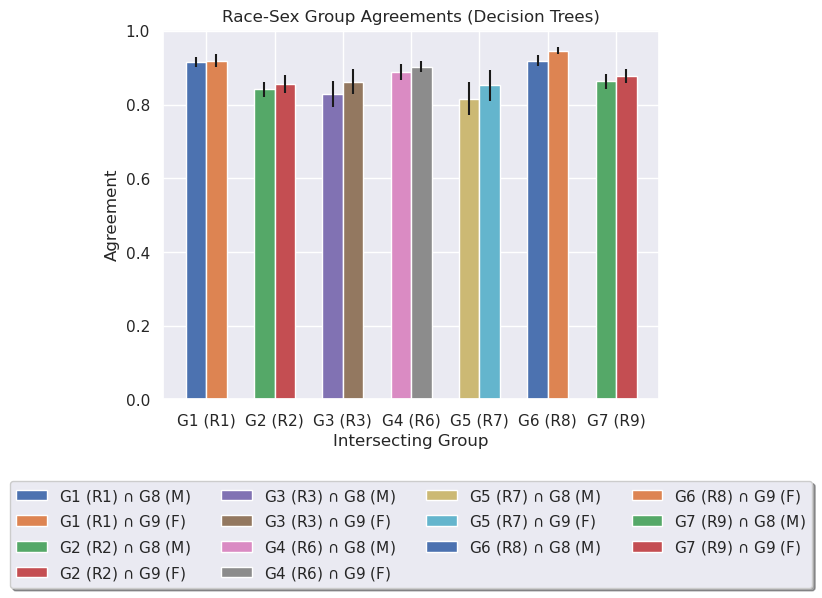

In [9]:
if FOLKTABLES:
    fig, ax = plt.subplots()
    plot_race_agreements(ax, dt_race_sex_agree, race_sex_pairs, group_names, 
                        title="Race-Sex Group Agreements (Decision Trees)")
    plt.savefig('final_plots/{}/race_sex_agree.png'.format(DATASET))
    plt.show()

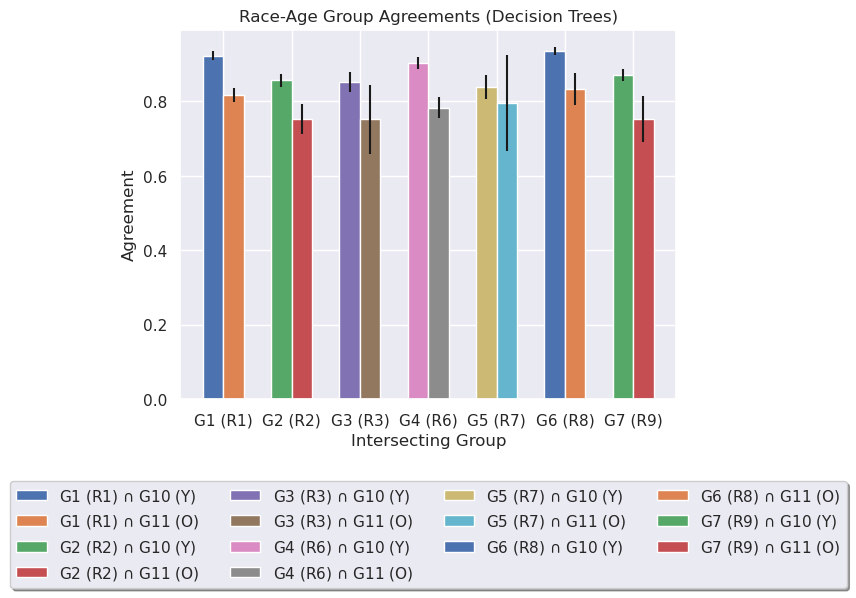

In [10]:
if FOLKTABLES:
    fig, ax = plt.subplots()
    plot_race_agreements(ax, dt_race_age_agree, race_age_pairs, group_names, 
                        title="Race-Age Group Agreements (Decision Trees)")
    plt.savefig('final_plots/{}/race_age_agree.png'.format(DATASET))
    plt.show()

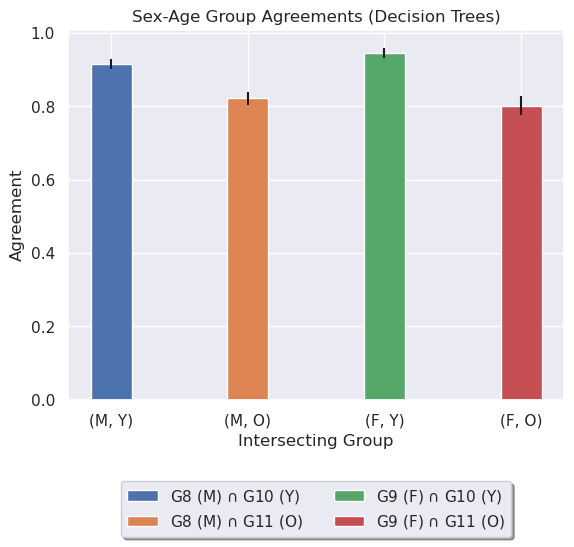

In [11]:
if FOLKTABLES:
    fig, ax = plt.subplots()
    plot_sex_age_agreements(ax, dt_sex_age_agree, sex_age_pairs, group_names, 
                        title="Sex-Age Group Agreements (Decision Trees)")
    plt.savefig('final_plots/{}/sex_age_agree.png'.format(DATASET))
    plt.show()

In [12]:
# Plot group-conditional agreements
if not FOLKTABLES:
    fig, ax = plt.subplots()
    plot_adult_agreements(ax, dt_train_agree_stats, 
                        group_pairs, group_names, 
                        model_class="Decision Tree",
                        xticks=agreement_ticks)
    plt.savefig('final_plots/{}/agree.png'.format(DATASET))
    plt.show()

# Comparison: Per-group ERM (Random Forest) vs. Ensemble Methods (Trees)

In [13]:
# Get best parameters for each model
SAVE_DATA_PATH = '{}_agreement_data/'.format(DATASET)
with open(os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl'), 'rb') as f:
    dt_params = pickle.load(f)
with open(os.path.join(SAVE_DATA_PATH, 'rf_params.pkl'), 'rb') as f:
    rf_params = pickle.load(f)
with open(os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl'), 'rb') as f:
    gb_params = pickle.load(f)
with open(os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl'), 'rb') as f:
    xgb_params = pickle.load(f)

In [14]:
# All the experiments for this part are done in bootstrap_errs.py
RESULTS_PATH = 'final_errs/'
with open(os.path.join(RESULTS_PATH, '{}_dt_errs.pkl'.format(DATASET)), 'rb') as f:
    dt_errs_stats = pickle.load(f)
with open(os.path.join(RESULTS_PATH, '{}_dt_erm_errs.pkl'.format(DATASET)), 'rb') as f:
    dt_erm_errs_stats = pickle.load(f)
with open(os.path.join(RESULTS_PATH, '{}_rf_errs.pkl'.format(DATASET)), 'rb') as f:
    rf_errs_stats = pickle.load(f)
with open(os.path.join(RESULTS_PATH, '{}_gb_errs.pkl'.format(DATASET)), 'rb') as f:
    gb_errs_stats = pickle.load(f)
with open(os.path.join(RESULTS_PATH, '{}_xgb_errs.pkl'.format(DATASET)), 'rb') as f:
    xgb_errs_stats = pickle.load(f)

In [15]:
# Error rate plots
from plotting_utils import plot_errors

if not FOLKTABLES:
    fig, ax = plt.subplots()
    fig.set_size_inches(15.5, 8.5)
    bar_width = 0.1
    index = np.arange(num_groups)

    for g in range(num_groups):
        if g == 0:
            ax.bar(g - 2.5 * bar_width, dt_errs_stats[g][0], bar_width, yerr=dt_errs_stats[g][1], capsize=3, label="Decision Tree (group ERM)",
            color="blue")
            ax.bar(g - 1.5 * bar_width, dt_erm_errs_stats[g][0], bar_width, yerr=dt_erm_errs_stats[g][1], capsize=3, label="Decision Tree (ERM)", color="salmon")
            ax.bar(g - 0.5 * bar_width, rf_errs_stats[g][0], bar_width, yerr=rf_errs_stats[g][1], capsize=3, label="Random Forest (ERM)", color="green")
            ax.bar(g + 0.5 * bar_width, gb_errs_stats[g][0], bar_width, yerr=gb_errs_stats[g][1], capsize=3, label="Gradient Boosting (ERM)", color="purple")
            ax.bar(g + 1.5 * bar_width, xgb_errs_stats[g][0], bar_width, yerr=xgb_errs_stats[g][1], capsize=3, label="XGBoost (ERM)", color="orange")
        else:
            ax.bar(g - 2.5 * bar_width, dt_errs_stats[g][0], bar_width, yerr=dt_errs_stats[g][1], capsize=3, color="blue")
            ax.bar(g - 1.5 * bar_width, dt_erm_errs_stats[g][0], bar_width, yerr=dt_erm_errs_stats[g][1], capsize=3, color="salmon")
            ax.bar(g - 0.5 * bar_width, rf_errs_stats[g][0], bar_width, yerr=rf_errs_stats[g][1], capsize=3, color="green")
            ax.bar(g + 0.5 * bar_width, gb_errs_stats[g][0], bar_width, yerr=gb_errs_stats[g][1], capsize=3, color="purple")
            ax.bar(g + 1.5 * bar_width, xgb_errs_stats[g][0], bar_width, yerr=xgb_errs_stats[g][1], capsize=3, color="orange")
    ax.set_ylabel('Group-conditional Error Rate')
    ax.set_title('Group-conditional Error Rates for Decision Tree vs. Ensemble Methods ({})'.format(DATASET))

    xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
    ax.set_xticks(index, xticks)
    ax.legend()
    plt.savefig('final_plots/{}/errors.png'.format(DATASET))
    plt.show()

In [16]:
# There are a lot more plots for FOLKTABLES datasets because intersections
from plotting_utils import plot_errors

if FOLKTABLES:
    disjoint_names = ["ALL", "R1", "R2", "R3", "R6", "R7", "R8", "R9", 
                    "M", "F", "Y", "O"]
    race_names = ["R1", "R2", "R3", "R6", "R7", "R8", "R9"]
    sex_names = ["M", "F"]
    age_names = ["Y", "O"]
    race_sex_names = []
    race_age_names = []
    sex_age_names = []
    race_sex_age_names = [[] for r in race_names]

    # Get group membership Boolean arrays
    DISJOINT_IDX = slice(12)
    RACE_SEX_IDX = slice(12, 26)
    RACE_AGE_IDX = slice(26, 40)
    SEX_AGE_IDX = slice(40, 44)
    RACE_SEX_AGE_IDX = slice(44, len(group_members_all))
    disjoint_groups = group_members_all[DISJOINT_IDX]
    race_sex_groups = group_members_all[RACE_SEX_IDX]
    race_age_groups = group_members_all[RACE_AGE_IDX]
    sex_age_groups = group_members_all[SEX_AGE_IDX]
    race_sex_age_groups = group_members_all[RACE_SEX_AGE_IDX]

    # Race-Sex Group Names
    for r in race_names:
        for s in sex_names:
            race_sex_names.append("({},{})".format(r, s))

    # Race-Age Group Names
    for r in race_names:
        for a in age_names:
            race_age_names.append("({},{})".format(r, a))

    # Sex-Age Group Names
    for s in sex_names:
        for a in age_names:
            sex_age_names.append("({},{})".format(s, a))

    # Race-Sex-Age Group Names
    for i, r in enumerate(race_names):
        for s in sex_names:
            for a in age_names:
                race_sex_age_names[i].append("({},{},{})".format(r,s,a))

    # Race-Sex-Age Group Indices
    race_sex_age_indices = {}
    for i in range(len(race_names)):
        race_sex_age_indices[i] = slice(44 + 4*i, 48 + 4*i)

In [17]:
# Fix errs_stats to fit with matplotlib error bars
if FOLKTABLES:
    dt_errs_stats_new = []
    for i in range(len((dt_errs_stats))):
        dt_errs_stats_new.append((dt_errs_stats[i][0], dt_errs_stats[i][0] -
                                dt_errs_stats[i][1][0]))
    dt_erm_errs_stats_new = []
    for i in range(len((dt_erm_errs_stats))):
        dt_erm_errs_stats_new.append((dt_erm_errs_stats[i][0], 
                                    dt_erm_errs_stats[i][0] - dt_erm_errs_stats[i][1][0]))
    rf_errs_stats_new = []
    for i in range(len((rf_errs_stats))):
        rf_errs_stats_new.append((rf_errs_stats[i][0], rf_errs_stats[i][0] -
                                rf_errs_stats[i][1][0]))
    gb_errs_stats_new = []
    for i in range(len((gb_errs_stats))):
        gb_errs_stats_new.append((gb_errs_stats[i][0], gb_errs_stats[i][0] -
                                gb_errs_stats[i][1][0]))
    xgb_errs_stats_new = []
    for i in range(len((xgb_errs_stats))):
        xgb_errs_stats_new.append((xgb_errs_stats[i][0], xgb_errs_stats[i][0] -
                                xgb_errs_stats[i][1][0]))

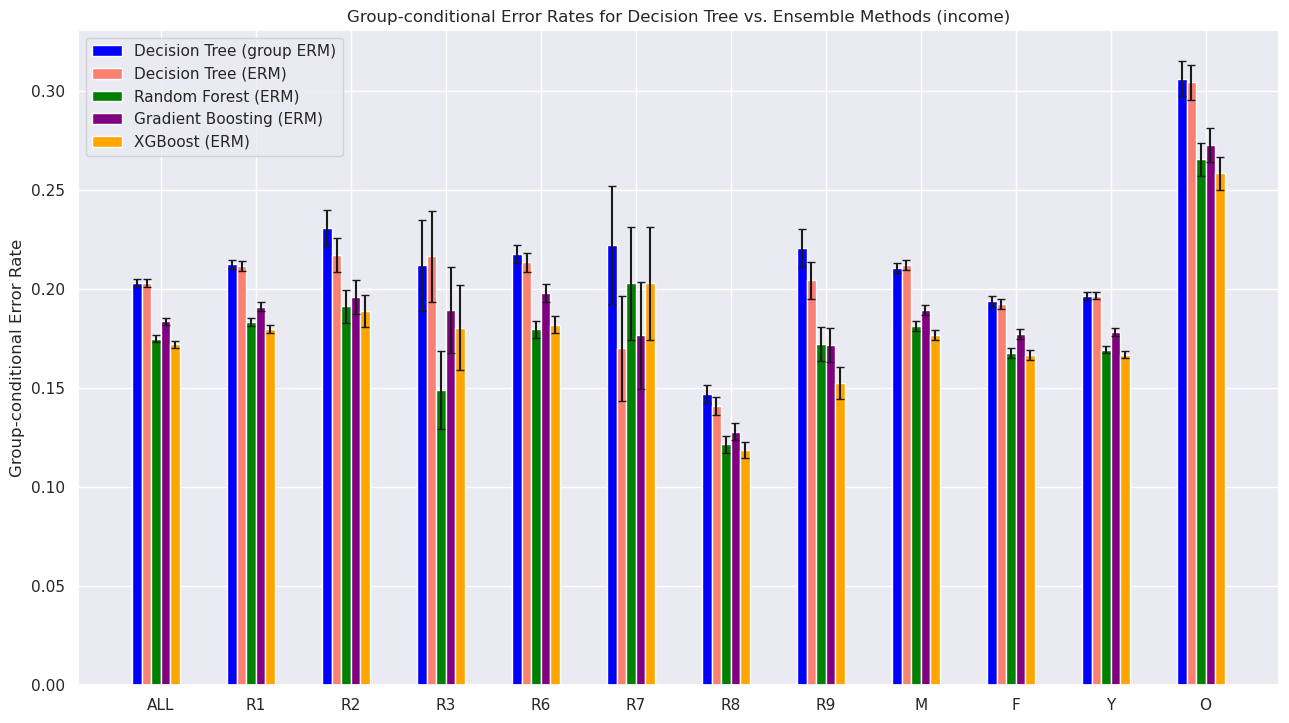

In [18]:
# Disjoint groups plot
if FOLKTABLES:
    fig, ax = plt.subplots()
    fig.set_size_inches(15.5, 8.5)
    plot_errors(ax, dt_errs_stats_new[DISJOINT_IDX], 
                dt_erm_errs_stats_new[DISJOINT_IDX],
                rf_errs_stats_new[DISJOINT_IDX], 
                gb_errs_stats_new[DISJOINT_IDX], 
                xgb_errs_stats_new[DISJOINT_IDX], 
                disjoint_names[DISJOINT_IDX], 
                DATASET)
    plt.savefig('final_plots/{}/errors.png'.format(DATASET))
    plt.show()

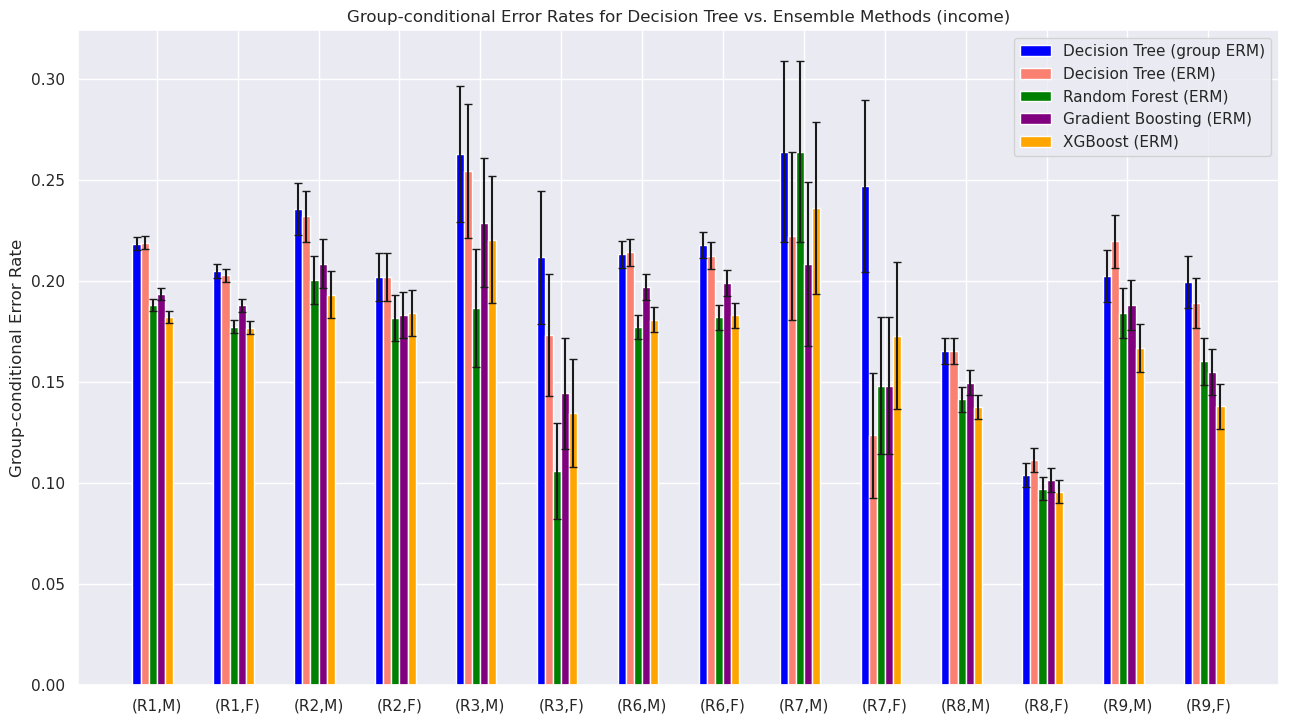

In [19]:
# Race-Sex plot
if FOLKTABLES:
    fig, ax = plt.subplots()
    fig.set_size_inches(15.5, 8.5)
    plot_errors(ax, dt_errs_stats_new[RACE_SEX_IDX], 
                dt_erm_errs_stats_new[RACE_SEX_IDX],
                rf_errs_stats_new[RACE_SEX_IDX], 
                gb_errs_stats_new[RACE_SEX_IDX], 
                xgb_errs_stats_new[RACE_SEX_IDX], 
                race_sex_names, DATASET)
    plt.savefig('final_plots/{}/race_sex_errors.png'.format(DATASET))
    plt.show()

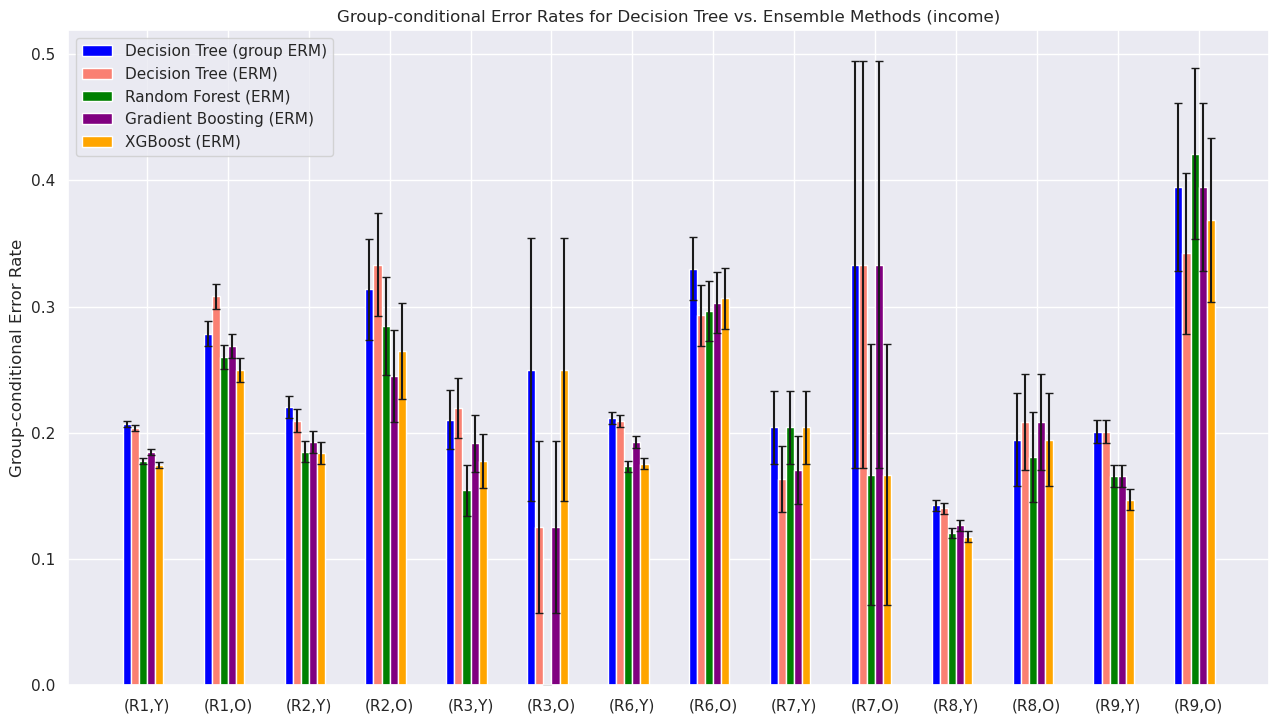

In [20]:
# Race-Age plot
if FOLKTABLES:
    fig, ax = plt.subplots()
    fig.set_size_inches(15.5, 8.5)
    plot_errors(ax, dt_errs_stats_new[RACE_AGE_IDX], 
                dt_erm_errs_stats_new[RACE_AGE_IDX],
                rf_errs_stats_new[RACE_AGE_IDX], 
                gb_errs_stats_new[RACE_AGE_IDX], 
                xgb_errs_stats_new[RACE_AGE_IDX], 
                race_age_names, DATASET)
    plt.savefig('final_plots/{}/race_age_errors.png'.format(DATASET))
    plt.show()

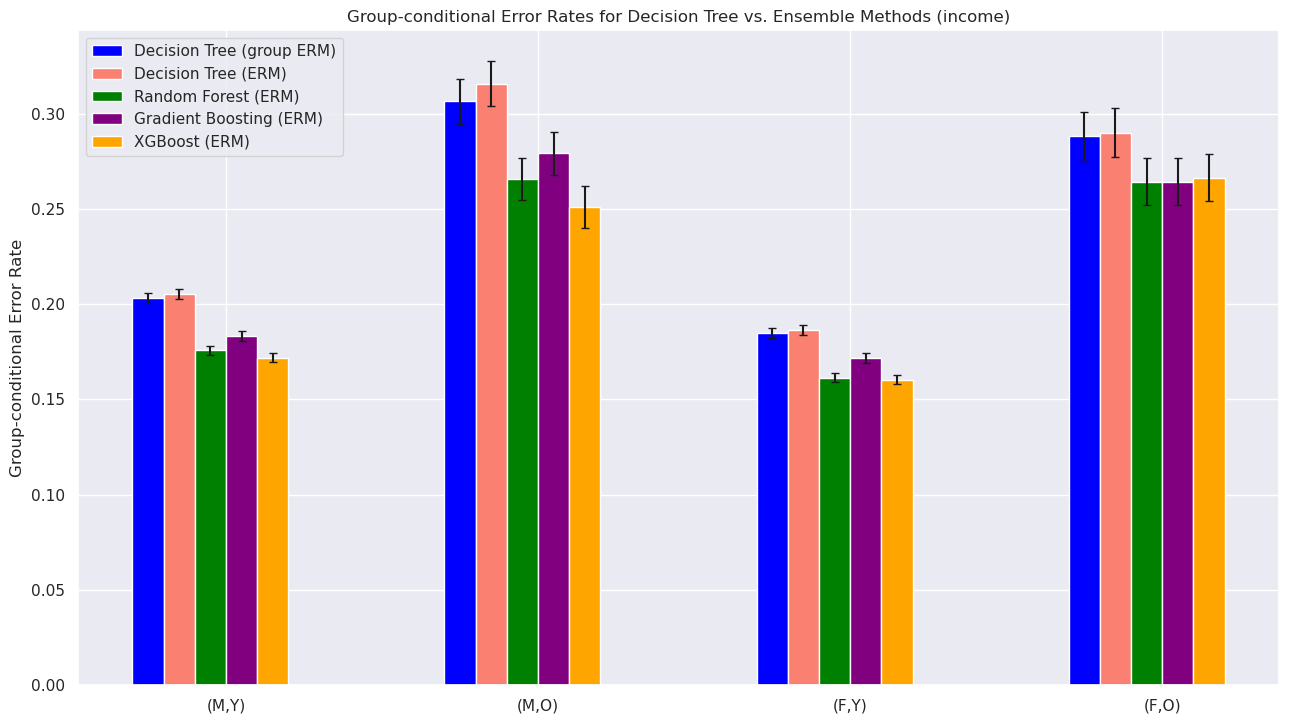

In [21]:
# Sex-Age plot
if FOLKTABLES:
    fig, ax = plt.subplots()
    fig.set_size_inches(15.5, 8.5)
    plot_errors(ax, dt_errs_stats_new[SEX_AGE_IDX], 
                dt_erm_errs_stats_new[SEX_AGE_IDX],
                rf_errs_stats_new[SEX_AGE_IDX], 
                gb_errs_stats_new[SEX_AGE_IDX], 
                xgb_errs_stats_new[SEX_AGE_IDX], 
                sex_age_names, DATASET)
    plt.savefig('final_plots/{}/sex_age_errors.png'.format(DATASET))
    plt.show()

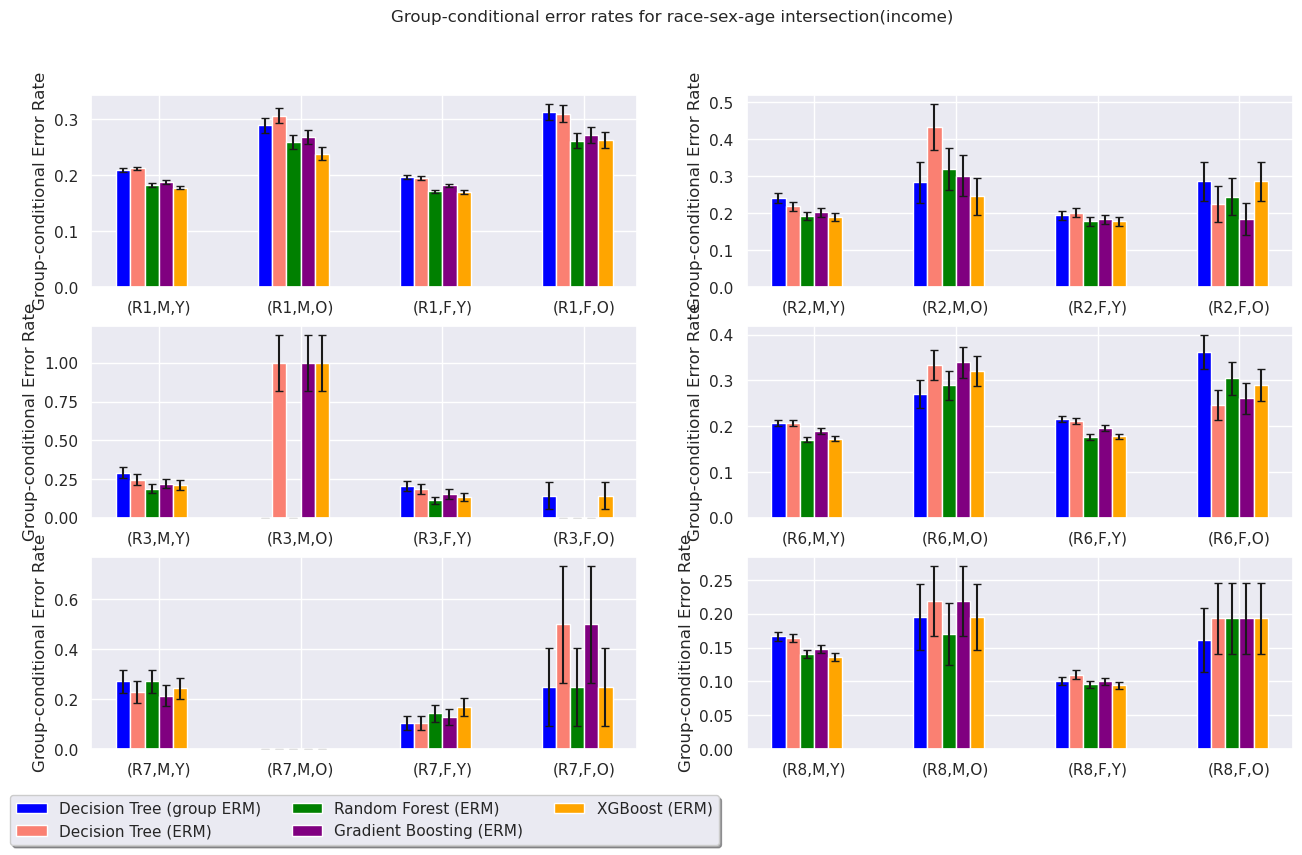

In [22]:
# Race-Sex-Age plots
if FOLKTABLES:
    fig, axs = plt.subplots(3, 2)
    fig.suptitle('Group-conditional error rates for race-sex-age intersection({})'.format(DATASET), fontsize=12)
    fig.set_size_inches(15.5, 8.5)
    plot_errors(axs[0][0], dt_errs_stats_new[race_sex_age_indices[0]], 
                dt_erm_errs_stats_new[race_sex_age_indices[0]],
                rf_errs_stats_new[race_sex_age_indices[0]], 
                gb_errs_stats_new[race_sex_age_indices[0]], 
                xgb_errs_stats_new[race_sex_age_indices[0]], 
                race_sex_age_names[0], DATASET, legend=False, title=False, ylabel=False)
    plot_errors(axs[0][1], dt_errs_stats_new[race_sex_age_indices[1]], 
                dt_erm_errs_stats_new[race_sex_age_indices[1]],
                rf_errs_stats_new[race_sex_age_indices[1]], 
                gb_errs_stats_new[race_sex_age_indices[1]], 
                xgb_errs_stats_new[race_sex_age_indices[1]], 
                race_sex_age_names[1], DATASET, legend=False, title=False, ylabel=False)
    plot_errors(axs[1][0], dt_errs_stats_new[race_sex_age_indices[2]], 
                dt_erm_errs_stats_new[race_sex_age_indices[2]],
                rf_errs_stats_new[race_sex_age_indices[2]], 
                gb_errs_stats_new[race_sex_age_indices[2]], 
                xgb_errs_stats_new[race_sex_age_indices[2]], 
                race_sex_age_names[2], DATASET, legend=False, title=False, ylabel=False)
    plot_errors(axs[1][1], dt_errs_stats_new[race_sex_age_indices[3]], 
                dt_erm_errs_stats_new[race_sex_age_indices[3]],
                rf_errs_stats_new[race_sex_age_indices[3]], 
                gb_errs_stats_new[race_sex_age_indices[3]], 
                xgb_errs_stats_new[race_sex_age_indices[3]], 
                race_sex_age_names[3], DATASET, legend=False, title=False,
                ylabel=False)
    plot_errors(axs[2][0], dt_errs_stats_new[race_sex_age_indices[4]], 
                dt_erm_errs_stats_new[race_sex_age_indices[4]],
                rf_errs_stats_new[race_sex_age_indices[4]], 
                gb_errs_stats_new[race_sex_age_indices[4]], 
                xgb_errs_stats_new[race_sex_age_indices[4]], 
                race_sex_age_names[4], DATASET, legend=False, title=False)
    plot_errors(axs[2][1], dt_errs_stats_new[race_sex_age_indices[5]], 
                dt_erm_errs_stats_new[race_sex_age_indices[5]],
                rf_errs_stats_new[race_sex_age_indices[5]], 
                gb_errs_stats_new[race_sex_age_indices[5]], 
                xgb_errs_stats_new[race_sex_age_indices[5]], 
                race_sex_age_names[5], DATASET, legend=False, title=False,
                ylabel=False)

    axs[2][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
    plt.savefig('final_plots/{}/race_sex_age_errors.png'.format(DATASET))
    plt.show()